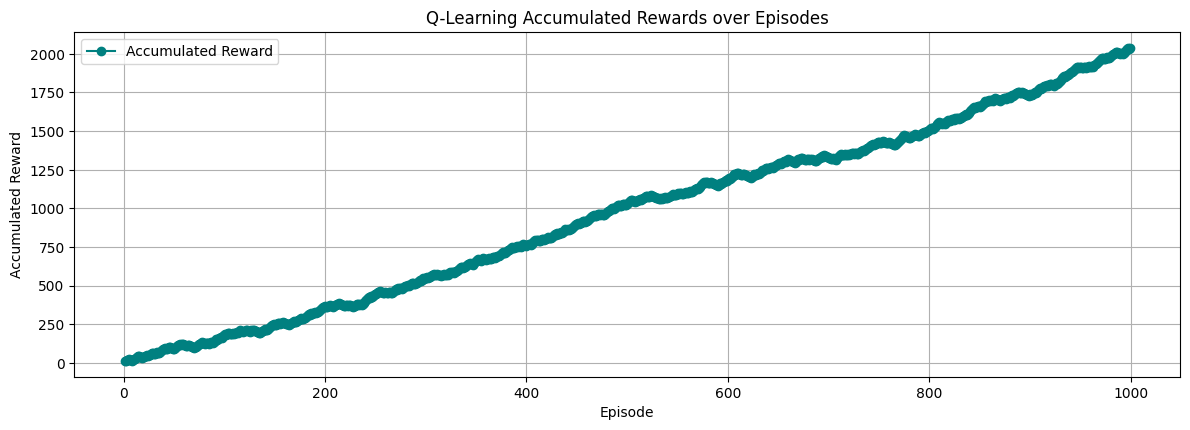

In [4]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from fuzzywuzzy import fuzz

# Load datasets
data = pd.read_csv('../datasets/data.csv')
df_books = pd.read_csv('../datasets/book_filtered_data.csv')
df_songs = pd.read_csv('../datasets/music_filtered_data.csv')
df_movies = pd.read_csv('../datasets/movie_filtered_data.csv')

data['imm_book_sugg'] = ''
data['imm_music_sugg'] = ''
data['imm_movie_sugg'] = ''

# Define mental states and number of users
mental_states = ['happy', 'sad', 'stressed', 'relaxed']
num_users = 1000

# Initialize Q-table
Q = defaultdict(lambda: defaultdict(float))

# Define parameters
alpha = 0.1  # Learning rate
gamma = 0.9  # Discount factor
epsilon = 0.2  # Exploration rate
num_episodes = 1000

# Reward mapping
def get_reward(feedback):
    if feedback == "good":
        return 7
    elif feedback == "bad":
        return -3
    elif feedback == "skip":
        return -2
    else:
        return 0

# Function to choose an action using epsilon-greedy policy

def choose_action(state, actions):
    state_tuple = state_to_tuple(state)
    if np.random.rand() < epsilon:
        return random.choice(actions)
    else:
        q_values = [Q[state_tuple][action] for action in actions]
        max_q = max(q_values)
        max_actions = [actions[i] for i, q in enumerate(q_values) if q == max_q]
        return random.choice(max_actions)


# Extract state for Q-learning
def get_state(df, user_id, mental_state):
    user_row = df[(df["user_id"] == user_id) & (df["mental_state"] == mental_state)]
    if not user_row.empty:
        user_row = user_row.iloc[0]
        books_preferences = user_row["books_preferences"]
        films_preferences = user_row["film_preferences"]
        music_preferences = user_row["music_preferences"]
    else:
        books_preferences = []
        films_preferences = []
        music_preferences = []
    return {'user_id': user_id, 'mental_state': mental_state, 'books': books_preferences, 'films': films_preferences, 'music': music_preferences}

# Convert state to tuple
def state_to_tuple(state):
    return (state['user_id'], state['mental_state'], tuple(state['books']), tuple(state['films']), tuple(state['music']))

# Function to get user's preferences network
def get_user_pref_network(df, user_id):
    user_row = df[(df["user_id"] == user_id)]
    if not user_row.empty:
        user_row = user_row.iloc[0]
        books_preferences = user_row["books_preferences"]
        films_preferences = user_row["film_preferences"]
        music_preferences = user_row["music_preferences"]
    else:
        books_preferences = []
        films_preferences = []
        music_preferences = []
    return books_preferences, films_preferences, music_preferences

# Function to get matching value
def get_matching_value(book, music, film, user_id, data):
    book_1, film_1, music_1 = get_user_pref_network(data, user_id)
    book_score = fuzz.token_set_ratio(book, book_1)
    music_score = fuzz.token_set_ratio(music, music_1)
    film_score = fuzz.token_set_ratio(film, film_1)
    return (book_score + music_score + film_score) / 3

# Function to get similar users
def get_similar_users(data, user_id, mental_state):
    similar_users = []
    for idx, row in data.iterrows():
        if row['mental_state'] == mental_state:
            matching_value = get_matching_value(row['books_preferences'], row['music_preferences'], row['film_preferences'], user_id, data)
            if matching_value > 85:
                similar_users.append(user_id)
    return similar_users

# Function to get ego suggestions
def get_ego_suggestions(similar_users_high, data, mental_state):
    book_suggestions = []
    music_suggestions = []
    film_suggestions = []
    for user_id in similar_users_high:
        user_row = data[(data["user_id"] == user_id) & (data["mental_state"] == mental_state)]
        user_row = user_row.iloc[0]
        book_suggestions.append(user_row['imm_book_sugg'])
        music_suggestions.append(user_row['imm_music_sugg'])
        film_suggestions.append(user_row['imm_movie_sugg'])
    return book_suggestions, music_suggestions, film_suggestions

# Function to get suggestions from user preferences
def get_suggestions_from_user_pref(user_id, book_data, film_data, music_data, mental_state, data):
    max_elements = 100
    state_id = get_state(data, user_id, mental_state)
    book_preferences = state_id['books']
    music_preferences = state_id['music']
    film_preferences = state_id['films']
    books = book_data.loc[book_data['genre'].apply(lambda x: any(g in x for g in book_preferences)), 'name'].tolist()[:max_elements]
    music = music_data.loc[music_data['genre'].apply(lambda x: any(g in x for g in music_preferences)), 'name'].tolist()[:max_elements]
    film = film_data.loc[film_data['genre'].apply(lambda x: any(g in x for g in film_preferences)), 'name'].tolist()[:max_elements]
    return books, music, film

# Function to get suggestions from exploration
def get_suggestions_from_explore(user_id, book_data, film_data, music_data, mental_state, data):
    max_elements = 100
    state_id = get_state(data, user_id, mental_state)
    books_unique = ["Fiction", "Classics", "Science Fiction", "Historical Fiction", "Horror", "Poetry", "Travel", "Nonfiction", "Comics", "Graphic Novels", "Young Adult", "Mystery", "Crime", "Thriller", "Romance", "Chick Lit", "Art", "Music", "Paranormal", "LGBT", "Children's", "Sports", "Memoir", "Biography", "Religion", "History", "Philosophy", "Self Help", "Psychology", "Business", "Spirituality", "Humor", "Science", "Business", "Religion"]
    music_unique = ['alternative', 'blues', 'dance', 'electro', 'electronic', 'folk', 'indie', 'metal', 'new-age', 'pop', 'rock', 'soul', 'world-music']
    movie_unique = ["Adventure", "Animation", "Children", "Comedy", "Fantasy", "Romance", "Horror", "Sci-Fi", "Western"]
    exp_book_pref = [item for item in books_unique if item not in state_id['books']]
    exp_music_pref = [item for item in music_unique if item not in state_id['music']]
    exp_film_pref = [item for item in movie_unique if item not in state_id['films']]
    books = book_data.loc[book_data['genre'].apply(lambda x: any(g in x for g in exp_book_pref)), 'name'].tolist()[:max_elements]
    music = music_data.loc[music_data['genre'].apply(lambda x: any(g in x for g in exp_music_pref)), 'name'].tolist()[:max_elements]
    film = film_data.loc[film_data['genre'].apply(lambda x: any(g in x for g in exp_film_pref)), 'name'].tolist()[:max_elements]
    return books, music, film

# Function to get exploration suggestions
def get_expl_suggest(ego, usr, ratio):
    suggestion = []
    if ego == ['']:
        suggestion = random.sample(usr, ratio)
    elif len(ego) < ratio:
        suggestion = random.sample(ego, len(ego))
        if len(usr) >= (ratio - len(ego)):
            suggestion += random.sample(usr, ratio - len(ego))
        else:
            suggestion += random.sample(usr, len(usr))
    else:
        suggestion = random.sample(ego, ratio)
    return suggestion


# Function to get selection feedback from the user
# def get_selection(book_suggestion, music_suggestion, film_suggestion):
#     break_val = 0
#     try_another = 0
#     selected_item = ''
#     feedback = ''
#     print('###################')
#     print('Types of selections')
#     print()
#     print('Books:', book_suggestion)
#     print('Music:', music_suggestion)
#     print('Films:', film_suggestion)
#     print()
#     print('Exit: e | Try Another: c | Select given: s')
#     print('###################')
#     selection = input('Enter your selection: ')
#     if selection == 'e':
#         break_val = 1
#     elif selection == 'c':
#         try_another = 1
#     elif selection == 's':
#         print('######################################')
#         selected_item = input('Enter selected item: ')
#         print('######################################')
#         feedback = input('Feedback (good or bad): ')
#     return {'break': break_val, 'skip': try_another, 'item': selected_item, 'feedback': feedback}

# Function to get selection feedback from the user (automated for training)
def get_selection(book_suggestion, music_suggestion, film_suggestion):
    selection = {}
    selection['break'] = 0  # Always continue during training
    selection['skip'] = 0   # No skipping during training
    selection['item'] = random.choice(book_suggestion + music_suggestion + film_suggestion)  # Randomly choose from suggestions
    # selection['feedback'] = 'good'  # Assume positive feedback for training
    feedback_options = ['good', 'bad']
    selection['feedback'] = random.choice(feedback_options)
    return selection


# Function to get the column name for immediate suggestion
def get_column_name(action):
    if action == 'book':
        return 'imm_book_sugg'
    elif action == 'music':
        return 'imm_music_sugg'
    elif action == 'film':
        return 'imm_movie_sugg'


def add_imm_suggestion(user_id, action, selected_item):

  column = get_column_name(action)
  data.loc[data['user_id'] == 1, column] = selected_item

def update_preferences(user_id, column, selected_item):

  if action == 'book':
    data = df_books
  elif action == 'music':
    data = df_songs
  else:
    data = df_movies

  item = data[data['name'] == selected_item]

  if not item.empty:
    prefernces = data['genre'].values[0]

  else:
    None

# Function to get selected action based on item
def get_selected_action(selected_item, books, music, films):
    if selected_item in books:
        return 'book'
    elif selected_item in music:
        return 'music'
    elif selected_item in films:
        return 'film'
    else:
        return 'unknown'

# Function to update the Q-table
def update_q_table(state, action, reward, next_state, next_actions):
    state_tuple = state_to_tuple(state)
    next_state_tuple = state_to_tuple(next_state)
    best_next_action = max(Q[next_state_tuple], key=Q[next_state_tuple].get, default=None)
    td_target = reward + gamma * Q[next_state_tuple][best_next_action] if best_next_action else reward
    Q[state_tuple][action] += alpha * (td_target - Q[state_tuple][action])


    



# Run Q-learning
ratio = {'book': 3, 'music': 3, 'films': 3}
number_of_episoids = 1000
rewards = []
total_rewards = []
avg_rewards = []
q_value_changes = []
explore = 0
feedback = ''
action = ''

user_ids = data['user_id'].unique()
unique_ids_list = list(user_ids)

for episode in range(num_episodes):

    user_id = random.choice(unique_ids_list)
    mental_state = random.choice(mental_states)
    state = get_state(data, user_id, mental_state)
    
    # Get recommendations
    similar_users = get_similar_users(data, user_id, mental_state)
    book_ego, music_ego, film_ego = get_ego_suggestions(similar_users, data, mental_state)
    book_usr, music_usr, film_usr = get_suggestions_from_user_pref(user_id, df_books, df_movies, df_songs, mental_state, data)
    book_exp, music_exp, film_exp = get_suggestions_from_explore(user_id, df_books, df_movies, df_songs, mental_state, data)
    
    # Combine actions
    actions = ['book', 'music', 'film']
    book_suggestion = random.sample(book_exp, 3)
    film_suggestion = random.sample(film_exp, 3)
    music_suggestion = random.sample(music_exp, 3)
    
    # Choose action using epsilon-greedy policy
    action = choose_action(state, actions)
    
    # Get feedback and calculate reward
    selection = get_selection(book_suggestion, music_suggestion, film_suggestion)
    if selection['break'] == 1:
        break
    elif selection['skip'] == 1:
        feedback = 'skip'
    else:
        selected_item = selection['item']
        feedback = selection['feedback']
        action = get_selected_action(selected_item, book_suggestion, music_suggestion, film_suggestion)
    
    reward = get_reward(feedback)
    rewards.append(reward)
    
    # Update user preferences
    update_preferences(user_id, action, selected_item)
    
    # Get next state (assuming user state may change; here it is static for simplicity)
    next_state = state
    next_actions = actions
    
    # Update Q-table
    update_q_table(state, action, reward, next_state, next_actions)

    # Calculate and record convergence metrics
    if episode > 0:
        total_rewards.append(sum(rewards))
        avg_rewards.append(np.mean(total_rewards[-10:]))  # Average over last 10 episodes

    # print(f"Episode {episode + 1}: State={state}, Action={action}, Reward={reward}")




# Plot rewards and convergence metrics
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(range(1, len(total_rewards) + 1), total_rewards, marker='o', linestyle='-', color='teal', label='Accumulated Reward')
# plt.plot(range(1, len(avg_rewards) + 1), avg_rewards, marker='o', linestyle='-', color='r', label='Average Reward (last 10 episodes)')
plt.xlabel('Episode')
plt.ylabel('Accumulated Reward')
plt.title('Q-Learning Accumulated Rewards over Episodes')
plt.legend()
plt.grid(True)
    
# plt.subplot(2, 1, 2)
# plt.plot(range(1, len(q_value_changes) + 1), q_value_changes, marker='o', linestyle='-', color='g', label='Q-value Changes')
# plt.xlabel('Episode')
# plt.ylabel('Q-value Change')
# plt.title('Q-value Changes over Episodes')
# plt.legend()
# plt.grid(True)
    
plt.tight_layout()
plt.show()
